Sample based on event information from INGV catalog

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx

#select particular representative gauge
reg = 'SR'

if reg == 'SR':
    columnname = str(54)
elif reg == 'CT':
    columnname = str(41)


MLDir = '/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami' 

eve_info = pd.read_csv(f'{MLDir}/resources/processed/allinfo_eventsBS_PS53550.txt',sep=',')
offshore_info = pd.read_csv(f'{MLDir}/data/info/grid0_allpts87_alleve53550.offshore.txt',sep='\t')
onshore_info = pd.read_csv(f'{MLDir}/data/info/CDepth_{reg}_alleve53550.onshore.txt',sep='\t')

#add eve_id to offshore_info and onshore_info by splitting id at /

#mange id column
eve_info.rename(columns={'ID':'eve_id'}, inplace=True)
offshore_info['eve_id'] = offshore_info['id'].str.split('/').str[1]
onshore_info['eve_id'] = onshore_info['id'].str.split('/').str[1]

#keep only column gaugeno and eve_id
offshore_info = offshore_info[['eve_id',columnname]]
# onshore_info = onshore_info[['eve_id','max']]

#merge offshore and onshore
combined = pd.merge(offshore_info, onshore_info, on='eve_id', how='left')

#merge combined with eve_info
combined = pd.merge(combined, eve_info, on='eve_id', how='left')



Matplotlib created a temporary config/cache directory at /tmp/matplotlib-nvaynt43 because the default path (/home/naveen.raguramalinga/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/tmp/ipykernel_256403/2240535208.py:18: DtypeWarning: Columns (6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  eve_info = pd.read_csv(f'{MLDir}/resources/processed/allinfo_eventsBS_PS53550.txt',sep=',')


In [2]:
#get column names
# combined.columns.values.tolist()
# ['eve_id',
#  '41', #offshore gauge selected for sampling
#  'id',
#  'count',
#  'max',
#  'logsum',
#  'mean',
#  'sd',
#  'dzmin',
#  'dzmax',
#  'Source_Region',
#  'Type',
#  'Mag',
#  'lon',
#  'lat',
#  'SlipModel',
#  'Scaling',
#  'RuptureModel',
#  'Rigidity',
#  'Depth',
#  'Strike',
#  'Dip',
#  'Rake',
#  'Length',
#  'Area',
#  'Slip',
#  'Location',
#  'LocationCount',
#  'mean_prob']



In [3]:

#create a new dataframe with only the columns we need
combined = combined[['eve_id','id',columnname,'mean_prob','dzmax','dzmin','max','lon','lat','Location','LocationCount']]

#rename column gauge to max_off and change type to double
combined.rename(columns={columnname:'max_off'}, inplace=True)
combined['max_off'] = combined['max_off'].astype(np.double)

#get max abs deformation
combined['max_absdz'] = combined[['dzmax','dzmin']].abs().max(axis=1)

#if absolute value of dzmax or dzmin is less than 0.1, set event_type to 'near'(0) ie  else 'far'(1)
combined['event_type'] = combined['max_absdz'].apply(lambda x: 1 if abs(x)<0.1 else 0).astype(np.double)
# combined['event_type'] = combined['dzmax'].apply(lambda x: 1 if x<0.2 else 0).astype(np.double)

#importance variable
combined['importance'] = combined['mean_prob'] * combined['max_off'].astype(np.double)

# #count when importance is 0
# combined[combined['importance']==0]
# #set importance to 1e-10  if importance is 0
# combined['importance'] = combined['importance'].apply(lambda x: 1e-10 if x==0 else x)


#count number of events in each cluster of event_type
print(combined.groupby('event_type').count())

#creat uniform weights column
combined['uniform_wt'] = 1/len(combined)


            eve_id     id  max_off  mean_prob  dzmax  dzmin    max    lon  \
event_type                                                                  
0.0           9186   9186     9186       9186   9186   9186   9186   9186   
1.0          44364  44364    44364      44364  44364  44364  44364  44364   

              lat  Location  LocationCount  max_absdz  importance  
event_type                                                         
0.0          9186      9186           9186       9186        9186  
1.0         44364     44364          44364      44364       44364  


#add grid count based on grid size of 0.1 degree -->

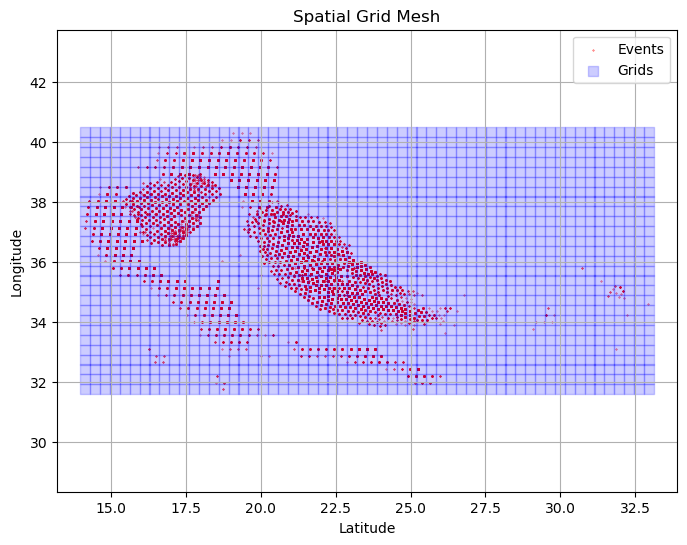

In [4]:
# Calculate the extent of latitude and longitude
min_lat = combined['lat'].min()
max_lat = combined['lat'].max()
min_lon = combined['lon'].min()
max_lon = combined['lon'].max()

# Define the size of the grid
grid_size = 0.33

# Create the latitude and longitude grids
lat_grids = np.arange(min_lat, max_lat + grid_size, grid_size)
lon_grids = np.arange(min_lon, max_lon + grid_size, grid_size)

# Create a meshgrid of latitude and longitude
mesh_lon,mesh_lat = np.meshgrid(lon_grids,lat_grids,)

# Plot the grid mesh
plt.figure(figsize=(8, 6))
plt.scatter(combined['lon'], combined['lat'], color='red', label='Events',s=0.1)
plt.scatter(mesh_lon,mesh_lat, color='blue', alpha=0.2, label='Grids', s=49, marker='s')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Grid Mesh')
plt.legend()
plt.grid(True)
plt.axis('equal')

plt.show()




In [5]:
# Calculate the number of events per grid
grid_counts = {}
for i in range(len(lat_grids) - 1):
    for j in range(len(lon_grids) - 1):
        lat_min, lat_max = lat_grids[i], lat_grids[i+1]
        lon_min, lon_max = lon_grids[j], lon_grids[j+1]
        count = combined[(combined['lat'] >= lat_min) & (combined['lat'] < lat_max) &
                         (combined['lon'] >= lon_min) & (combined['lon'] < lon_max)].shape[0]
        if count > 0:
            grid_id = f"{lat_min.round(3)},{lon_min.round(3)}"
            grid_counts[grid_id] = count

# Assign grid counts and grid ID to events
combined['gridcount'] = np.nan
combined['grid_id'] = np.nan
for index, event in combined.iterrows():
    lat, lon = event['lat'], event['lon']
    for grid_id, count in grid_counts.items():
        lat_min, lon_min = map(float, grid_id.split(","))
        lat_max, lon_max = lat_min + grid_size, lon_min + grid_size
        if lat_min <= lat < lat_max and lon_min <= lon < lon_max:
            combined.at[index, 'gridcount'] = count
            combined.at[index, 'grid_id'] = grid_id
            break

#if any entry nan for gridcount, set it to copy value of row above
combined['gridcount'] = combined['gridcount'].fillna(method='ffill')
combined['grid_id'] = combined['grid_id'].fillna(method='ffill')
         

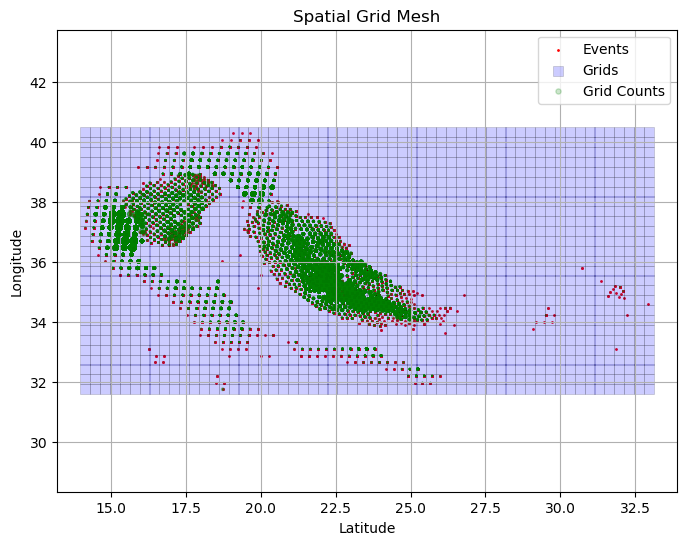

In [6]:
#plot grid counts and grid id
plt.figure(figsize=(8, 6))
plt.scatter(combined['lon'], combined['lat'], color='red', label='Events',s=1)
plt.scatter(mesh_lon,mesh_lat, color='blue', alpha=0.2, label='Grids', s=48, marker='s',linewidth =0.5, edgecolors='black')
plt.scatter(combined['lon'], combined['lat'], s=combined['gridcount']*0.015, color='green', alpha=0.2, label='Grid Counts')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Grid Mesh')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


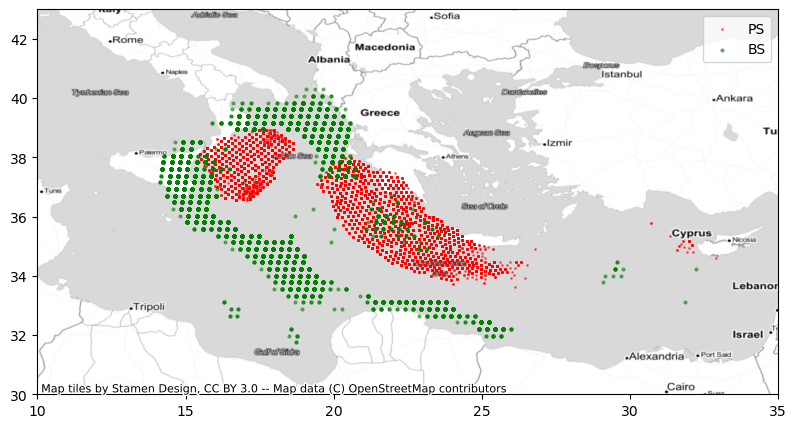

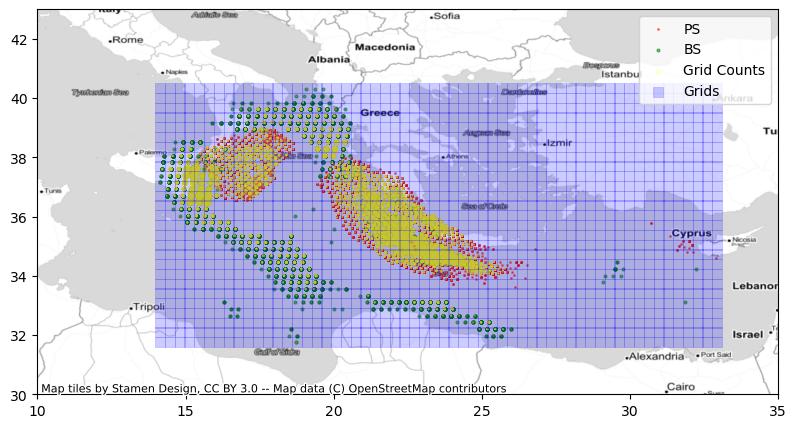

In [58]:
#plot location of events by event type
fig, ax = plt.subplots(figsize=(10,5))
#if BS or PS
ax = plt.scatter(combined[combined['id'].str[:2]=='PS']['lon'], combined[combined['id'].str[:2]=='PS']['lat'], alpha=0.5, label='PS',s=1,color='red')
ax = plt.scatter(combined[combined['id'].str[:2]=='BS']['lon'], combined[combined['id'].str[:2]=='BS']['lat'], alpha=0.5, label='BS', s=4,color='green')
# ax = plt.scatter(combined['lon'], combined['lat'], s=combined['gridcount']*0.01, color='yellow', alpha=0.1, label='Grid Counts')
# ax = plt.scatter(mesh_lon,mesh_lat, color='blue', alpha=0.2, label='Grids', s=50, marker='s',linewidth =0.5, edgecolors='blue')
plt.legend(loc='upper right')
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.Stamen.TonerLite)
plt.show()
#plot location of events by event type
fig, ax = plt.subplots(figsize=(10,5))
#if BS or PS
ax = plt.scatter(combined[combined['id'].str[:2]=='PS']['lon'], combined[combined['id'].str[:2]=='PS']['lat'], alpha=0.5, label='PS',s=1,color='red')
ax = plt.scatter(combined[combined['id'].str[:2]=='BS']['lon'], combined[combined['id'].str[:2]=='BS']['lat'], alpha=0.5, label='BS', s=4,color='green')
ax = plt.scatter(combined['lon'], combined['lat'], s=combined['gridcount']*0.015, color='yellow', alpha=0.1, label='Grid Counts')
ax = plt.scatter(mesh_lon,mesh_lat, color='blue', alpha=0.2, label='Grids', s=50, marker='s',linewidth =0.5, edgecolors='blue')
plt.legend(loc='upper right')
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.Stamen.TonerLite)
plt.show()

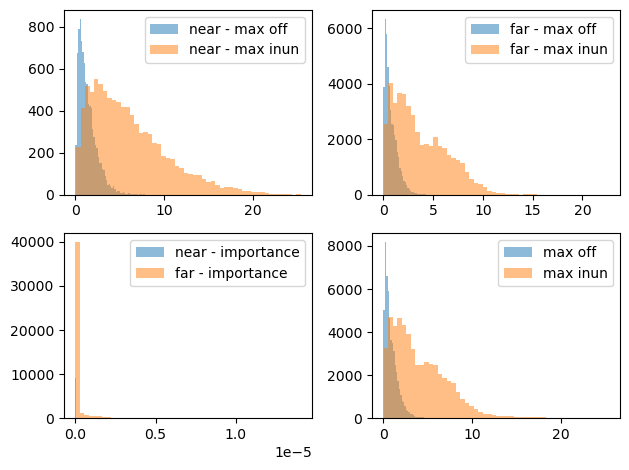

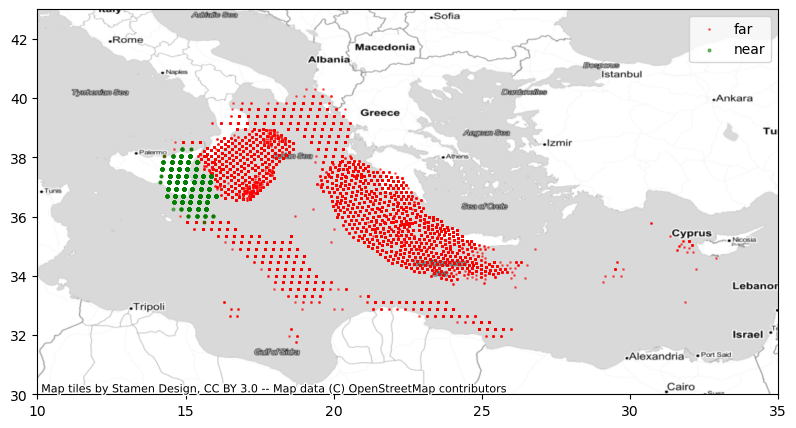

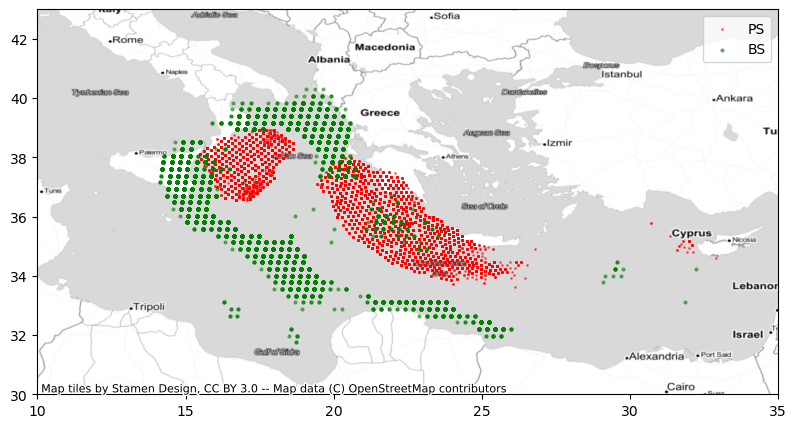

In [8]:
#distribution of events
fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0,0].hist(combined[combined['event_type']==0]['max_off'], bins=50, alpha=0.5, label='near - max off')
axs[0,0].hist(combined[combined['event_type']==0]['max'], bins=50, alpha=0.5, label='near - max inun')
axs[0,0].legend(loc='upper right')

axs[0,1].hist(combined[combined['event_type']==1]['max_off'], bins=50, alpha=0.5, label='far - max off')
axs[0,1].hist(combined[combined['event_type']==1]['max'], bins=50, alpha=0.5, label='far - max inun')
axs[0,1].legend(loc='upper right')

axs[1,0].hist(combined[combined['event_type']==0]['importance'], bins=50, alpha=0.5, label='near - importance')
axs[1,0].hist(combined[combined['event_type']==1]['importance'], bins=50, alpha=0.5, label='far - importance')
axs[1,0].legend(loc='upper right')

axs[1,1].hist(combined['max_off'], bins=50, alpha=0.5, label='max off')
axs[1,1].hist(combined['max'], bins=50, alpha=0.5, label='max inun')
axs[1,1].legend(loc='upper right')

#plot location of events by event type
fig, ax = plt.subplots(figsize=(10,5))
ax = plt.scatter(combined[combined['event_type']==1]['lon'], combined[combined['event_type']==1]['lat'], alpha=0.5, label='far',s=1,color='red')
ax = plt.scatter(combined[combined['event_type']==0]['lon'], combined[combined['event_type']==0]['lat'], alpha=0.5, label='near', s=4,color='green')
plt.legend(loc='upper right')
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.Stamen.TonerLite)

#plot location of events by event type
fig, ax = plt.subplots(figsize=(10,5))
#if BS or PS
ax = plt.scatter(combined[combined['id'].str[:2]=='PS']['lon'], combined[combined['id'].str[:2]=='PS']['lat'], alpha=0.5, label='PS',s=1,color='red')
ax = plt.scatter(combined[combined['id'].str[:2]=='BS']['lon'], combined[combined['id'].str[:2]=='BS']['lat'], alpha=0.5, label='BS', s=4,color='green')
plt.legend(loc='upper right')
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.Stamen.TonerLite)
plt.show()

In [9]:
#save sampling input to info folder
combined.to_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/info/sampling_input_{reg}_{columnname}.csv', index=False)

In [16]:
import numpy as np
import pandas as pd

np.random.seed(0)

def sample_train_events(data, #input dataframe with event info 
                        importance_column='mean_prob', #column name for importance weighted sampling
                        samples_per_bin=10, #no of events to sample per bin
                        bin_def = [0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,5.0], #bin width for wave height 
                        ): 

    #define bin edges
    bin_start = bin_def[:-1]
    bin_end = bin_def[1:]

    if np.any((data['mean_prob'] < 0) | (data[importance_column] < 0)):
        raise ValueError('event_rates and importance parameter must be nonnegative')
    
    sample = []
    for bin in list(zip(bin_start, bin_end)):
       
        #get events in this bin
        events_in_bin = data[(data['max_off'] >= bin[0]) & (data['max_off'] < bin[1])]
        print('Sampling',samples_per_bin, 'events in bin',bin,'from',len(events_in_bin),'events')
        
        rate_with_this_bin = np.sum(events_in_bin['mean_prob'] )    
        events_in_bin_copy = events_in_bin.copy()

        #sort by lat and lon
        events_in_bin_copy.sort_values(by=['lat', 'lon'], inplace=True)

        if importance_column == 'gridcount' or importance_column == 'LocationCount':
            # Print count of events per grid and print grid ID with the minimum count
            grid_counts = events_in_bin_copy.groupby('grid_id').count()['id']
            # Add the weights column
            events_in_bin_copy['norm_wt'] = events_in_bin_copy['grid_id'].map(lambda x: 1 / grid_counts[x])
            events_in_bin_copy['norm_wt'] /= np.sum(events_in_bin_copy['norm_wt'])      
        else:
            events_in_bin_copy.loc[:, 'norm_wt'] = events_in_bin[importance_column] / np.sum(events_in_bin[importance_column])  

        if samples_per_bin > 0 and np.sum(events_in_bin_copy['norm_wt']) > 0:
            #sample events from this bin weighted by norm_wt
            if len(events_in_bin) <= samples_per_bin:
                print('Less scenario to sample in this bin',bin,' -- need to be careful using samples will use sample with replacement')
                sampled_ids = np.random.choice(events_in_bin['id'],
                                                size=samples_per_bin,
                                                p=events_in_bin_copy['norm_wt'],
                                                replace=True,
                                                )
            else:
                sampled_ids = np.random.choice(events_in_bin['id'],
                                                size=samples_per_bin,
                                                p=events_in_bin_copy['norm_wt'],
                                                replace=False,
                                                )            
        #get the sampled events
        sample.append(pd.DataFrame({
            'id': sampled_ids,
            'bin_start': np.repeat(bin[0], samples_per_bin),
            'bin_end': np.repeat(bin[1], samples_per_bin),
            'rate_with_this_bin': np.repeat(rate_with_this_bin, samples_per_bin)
        }))
    
    return sample


In [53]:
#select particular representative gauge
reg = 'SR'

if reg == 'SR':
    columnname = str(54)
elif reg == 'CT':
    columnname = str(41)

#read combined dataframe
combined = pd.read_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/info/sampling_input_{reg}_{columnname}.csv')
temp = combined.groupby('event_type').get_group(0)

Sampling 40 events in bin (0.0, 0.14583333333333334) from 141 events
Sampling 40 events in bin (0.14583333333333334, 0.2916666666666667) from 543 events
Sampling 40 events in bin (0.2916666666666667, 0.4375) from 721 events
Sampling 40 events in bin (0.4375, 0.5833333333333334) from 764 events
Sampling 40 events in bin (0.5833333333333334, 0.7291666666666667) from 714 events
Sampling 40 events in bin (0.7291666666666667, 0.875) from 689 events
Sampling 40 events in bin (0.875, 1.0208333333333335) from 605 events
Sampling 40 events in bin (1.0208333333333335, 1.1666666666666667) from 559 events
Sampling 40 events in bin (1.1666666666666667, 1.3125) from 524 events
Sampling 40 events in bin (1.3125, 1.4583333333333335) from 446 events
Sampling 40 events in bin (1.4583333333333335, 1.6041666666666667) from 424 events
Sampling 40 events in bin (1.6041666666666667, 1.75) from 370 events
Sampling 40 events in bin (1.75, 1.8958333333333335) from 386 events
Sampling 40 events in bin (1.8958333

Sampling 40 events in bin (0.875, 1.0) from 2217 events
Sampling 40 events in bin (1.0, 1.125) from 2332 events
Sampling 40 events in bin (1.125, 1.25) from 1860 events
Sampling 40 events in bin (1.25, 1.375) from 1802 events
Sampling 40 events in bin (1.375, 1.5) from 1403 events
Sampling 40 events in bin (1.5, 1.625) from 1244 events
Sampling 40 events in bin (1.625, 1.75) from 904 events
Sampling 40 events in bin (1.75, 1.875) from 862 events
Sampling 40 events in bin (1.875, 2.0) from 584 events
Sampling 40 events in bin (2.0, 2.125) from 519 events
Sampling 40 events in bin (2.125, 2.25) from 410 events
Sampling 40 events in bin (2.25, 2.375) from 386 events
Sampling 40 events in bin (2.375, 2.5) from 252 events
Sampling 40 events in bin (2.5, 2.625) from 190 events
Sampling 40 events in bin (2.625, 2.75) from 150 events
Sampling 40 events in bin (2.75, 2.875) from 131 events
Sampling 40 events in bin (2.875, 3.0) from 77 events
Sampling 40 events in bin (3.0, 99.0) from 282 event

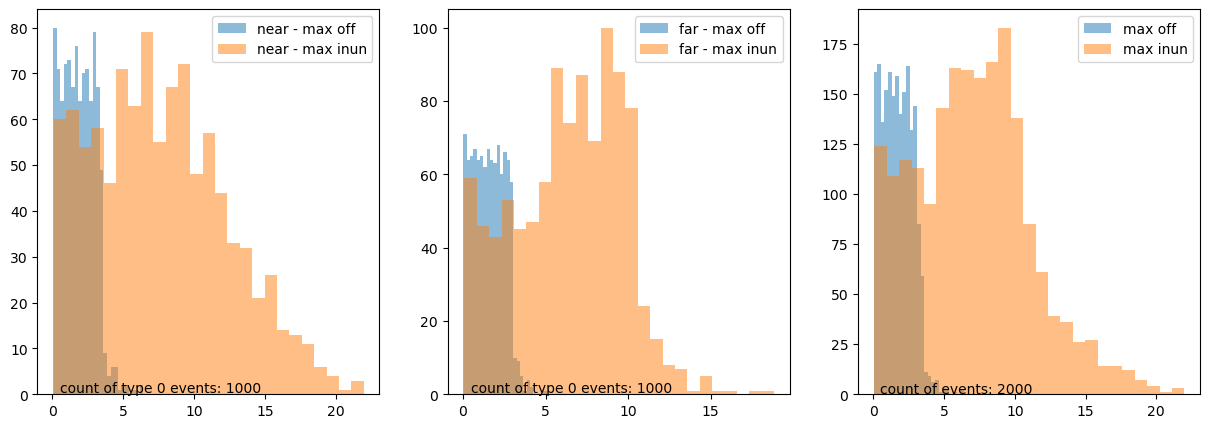

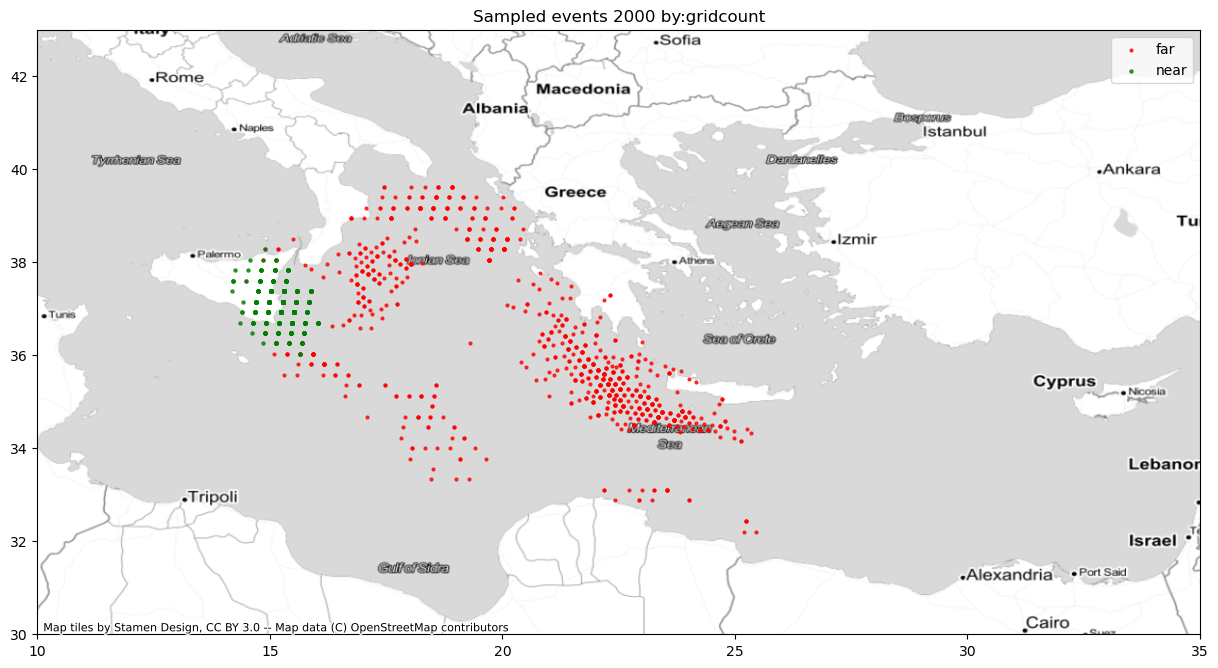

In [57]:
'split sampling in two steps for event type 0 and 1 then merge'
wt_para = 'gridcount' #'LocationCount', 'mean_prob', 'importance', 'uniform',gridcount
samples_per_bin = 40
bin_splits = 25

sample_step0 = sample_train_events(combined.groupby('event_type').get_group(0),
                                importance_column=wt_para,
                                samples_per_bin=samples_per_bin,
                                bin_def = np.append(np.linspace(0,3.5,bin_splits), 99))


sample_step1 = sample_train_events(combined.groupby('event_type').get_group(1),
                                importance_column=wt_para, 
                                samples_per_bin=samples_per_bin,
                                bin_def = np.append(np.linspace(0,3.0,bin_splits), 99))

sample_test = pd.concat([pd.concat(sample_step0, axis=0), pd.concat(sample_step1, axis=0)], axis=0)

#check unique events in sample
print(len(sample_test['id'].unique()),'out of ',len(sample_test))

#merge columns from combined to sample_test based on id
sample_test = pd.merge(sample_test, combined, on='id', how='left')

#plot 
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(sample_test[sample_test['event_type']==0]['max_off'], bins=bin_splits, alpha=0.5, label='near - max off')
axs[0].hist(sample_test[sample_test['event_type']==0]['max'], bins=bin_splits, alpha=0.5, label='near - max inun')
axs[0].text(0.5, 0.5, 'count of type 0 events: '+str(len(sample_test[sample_test['event_type']==0])))
axs[0].legend(loc='upper right')

axs[1].hist(sample_test[sample_test['event_type']==1]['max_off'], bins=bin_splits, alpha=0.5, label='far - max off')
axs[1].hist(sample_test[sample_test['event_type']==1]['max'], bins=bin_splits, alpha=0.5, label='far - max inun')
axs[1].text(0.5, 0.5,'count of type 0 events: '+str(len(sample_test[sample_test['event_type']==1])))
axs[1].legend(loc='upper right')

axs[2].hist(sample_test['max_off'], bins=bin_splits, alpha=0.5, label='max off')
axs[2].hist(sample_test['max'], bins=bin_splits, alpha=0.5, label='max inun')
axs[2].text(0.5, 0.5, 'count of events: '+str(len(sample_test)))
axs[2].legend(loc='upper right')
plt.savefig(MLDir + f'/model/{reg}/plot/sampledist_events{str(len(sample_test))}_{reg}_{columnname}.png', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(15,10))
ax.title.set_text('Sampled events ' + str(len(sample_test)) + ' by:' + wt_para)
ax = plt.scatter(sample_test[sample_test['event_type']==1]['lon'], sample_test[sample_test['event_type']==1]['lat'], alpha=0.75, label='far',s=4, color='red')
ax = plt.scatter(sample_test[sample_test['event_type']==0]['lon'], sample_test[sample_test['event_type']==0]['lat'], alpha=0.75, label='near', s=5, color='green')
plt.legend(loc='upper right')
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.Stamen.TonerLite)
plt.savefig(MLDir + f'/model/{reg}/plot/samplemap_events{str(len(sample_test))}_{reg}_{columnname}.png', bbox_inches='tight')


#save list of ids to txt file
sample_test['id'].to_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/events/sample_events{str(len(sample_test))}_{reg}_{columnname}.txt', header=False, index=None)

Sampling 10 events in bin (0.0, 0.14583333333333334) from 64 events
Sampling 10 events in bin (0.14583333333333334, 0.2916666666666667) from 345 events
Sampling 10 events in bin (0.2916666666666667, 0.4375) from 619 events
Sampling 10 events in bin (0.4375, 0.5833333333333334) from 771 events
Sampling 10 events in bin (0.5833333333333334, 0.7291666666666667) from 720 events
Sampling 10 events in bin (0.7291666666666667, 0.875) from 733 events
Sampling 10 events in bin (0.875, 1.0208333333333335) from 692 events
Sampling 10 events in bin (1.0208333333333335, 1.1666666666666667) from 601 events
Sampling 10 events in bin (1.1666666666666667, 1.3125) from 563 events
Sampling 10 events in bin (1.3125, 1.4583333333333335) from 449 events
Sampling 10 events in bin (1.4583333333333335, 1.6041666666666667) from 460 events
Sampling 10 events in bin (1.6041666666666667, 1.75) from 325 events
Sampling 10 events in bin (1.75, 1.8958333333333335) from 330 events
Sampling 10 events in bin (1.89583333

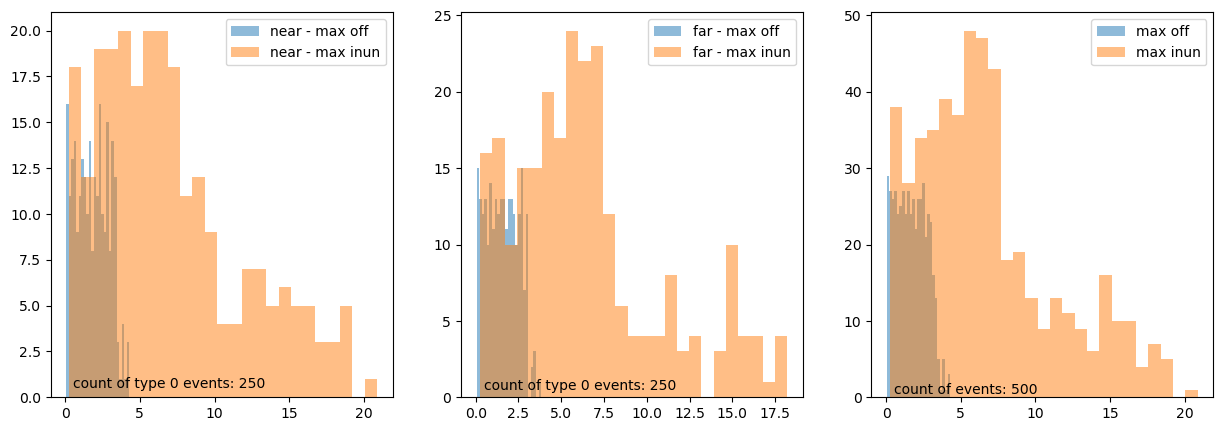

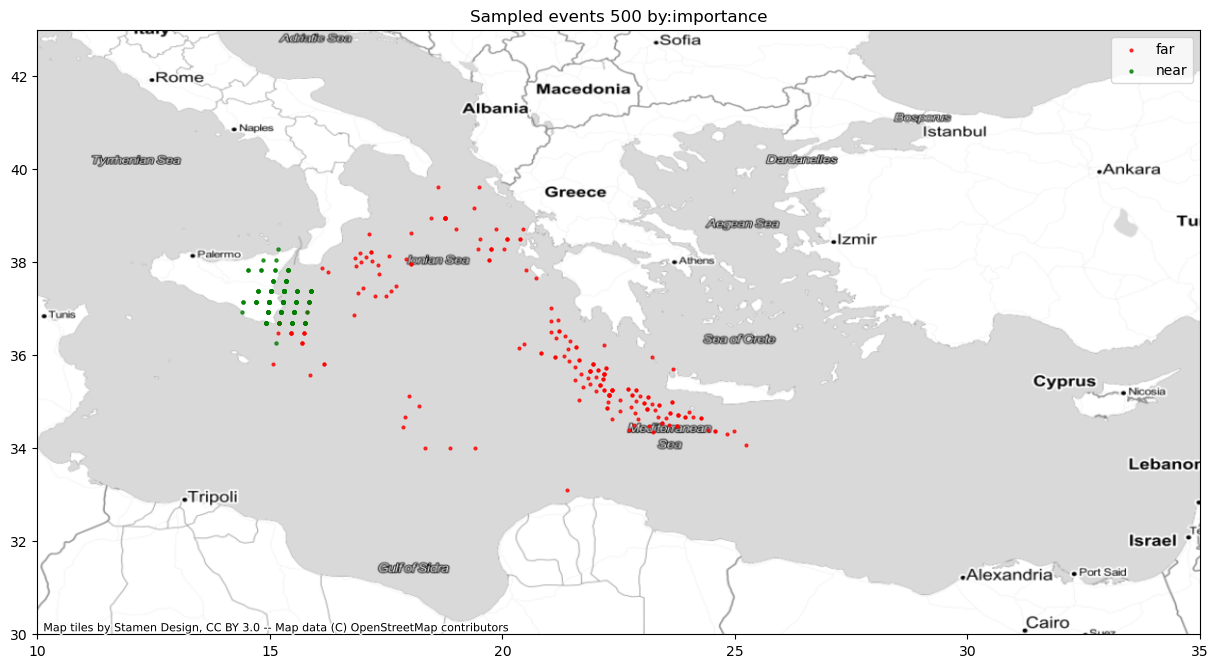

In [34]:
'split sampling in two steps for event type 0 and 1 then merge'
wt_para = 'importance' #'LocationCount', 'mean_prob', 'importance', 'uniform_wt'

sample_step0 = sample_train_events(combined.groupby('event_type').get_group(0),
                                importance_column=wt_para,
                                samples_per_bin=samples_per_bin,
                                bin_def = np.append(np.linspace(0,3.5,bin_splits), 99))

sample_step1 = sample_train_events(combined.groupby('event_type').get_group(1),
                                importance_column=wt_para, 
                                samples_per_bin=samples_per_bin,
                                bin_def = np.append(np.linspace(0,3.0,bin_splits), 99))

sample_test = pd.concat([pd.concat(sample_step0, axis=0), pd.concat(sample_step1, axis=0)], axis=0)

#check unique events in sample
print(len(sample_test['id'].unique()),'out of ',len(sample_test))

#merge columns from combined to sample_test based on id
sample_test = pd.merge(sample_test, combined, on='id', how='left')

#plot same but in multiple subplots as row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(sample_test[sample_test['event_type']==0]['max_off'], bins=bin_splits, alpha=0.5, label='near - max off')
axs[0].hist(sample_test[sample_test['event_type']==0]['max'], bins=bin_splits, alpha=0.5, label='near - max inun')
axs[0].text(0.5, 0.5, 'count of type 0 events: '+str(len(sample_test[sample_test['event_type']==0])))
axs[0].legend(loc='upper right')

axs[1].hist(sample_test[sample_test['event_type']==1]['max_off'], bins=bin_splits, alpha=0.5, label='far - max off')
axs[1].hist(sample_test[sample_test['event_type']==1]['max'], bins=bin_splits, alpha=0.5, label='far - max inun')
axs[1].text(0.5, 0.5, 'count of type 0 events: '+str(len(sample_test[sample_test['event_type']==1])))
axs[1].legend(loc='upper right')

axs[2].hist(sample_test['max_off'], bins=bin_splits, alpha=0.5, label='max off')
axs[2].hist(sample_test['max'], bins=bin_splits, alpha=0.5, label='max inun')
axs[2].text(0.5, 0.5, 'count of events: '+str(len(sample_test)))
axs[2].legend(loc='upper right')

fig, ax = plt.subplots(figsize=(15,10))
ax.title.set_text('Sampled events ' + str(len(sample_test)) + ' by:' + wt_para)
ax = plt.scatter(sample_test[sample_test['event_type']==1]['lon'], sample_test[sample_test['event_type']==1]['lat'], alpha=0.75, label='far',s=4, color='red')
ax = plt.scatter(sample_test[sample_test['event_type']==0]['lon'], sample_test[sample_test['event_type']==0]['lat'], alpha=0.75, label='near', s=5, color='green')
plt.legend(loc='upper right')
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.Stamen.TonerLite)
plt.show()



Sampling 10 events in bin (0.0, 0.14583333333333334) from 64 events
Sampling 10 events in bin (0.14583333333333334, 0.2916666666666667) from 345 events
Sampling 10 events in bin (0.2916666666666667, 0.4375) from 619 events
Sampling 10 events in bin (0.4375, 0.5833333333333334) from 771 events
Sampling 10 events in bin (0.5833333333333334, 0.7291666666666667) from 720 events
Sampling 10 events in bin (0.7291666666666667, 0.875) from 733 events
Sampling 10 events in bin (0.875, 1.0208333333333335) from 692 events
Sampling 10 events in bin (1.0208333333333335, 1.1666666666666667) from 601 events
Sampling 10 events in bin (1.1666666666666667, 1.3125) from 563 events
Sampling 10 events in bin (1.3125, 1.4583333333333335) from 449 events
Sampling 10 events in bin (1.4583333333333335, 1.6041666666666667) from 460 events
Sampling 10 events in bin (1.6041666666666667, 1.75) from 325 events
Sampling 10 events in bin (1.75, 1.8958333333333335) from 330 events
Sampling 10 events in bin (1.89583333

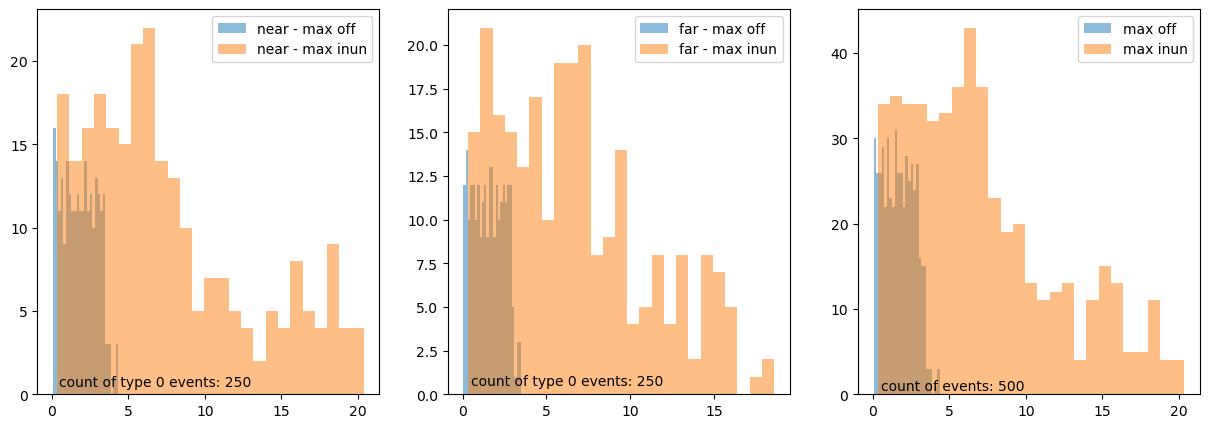

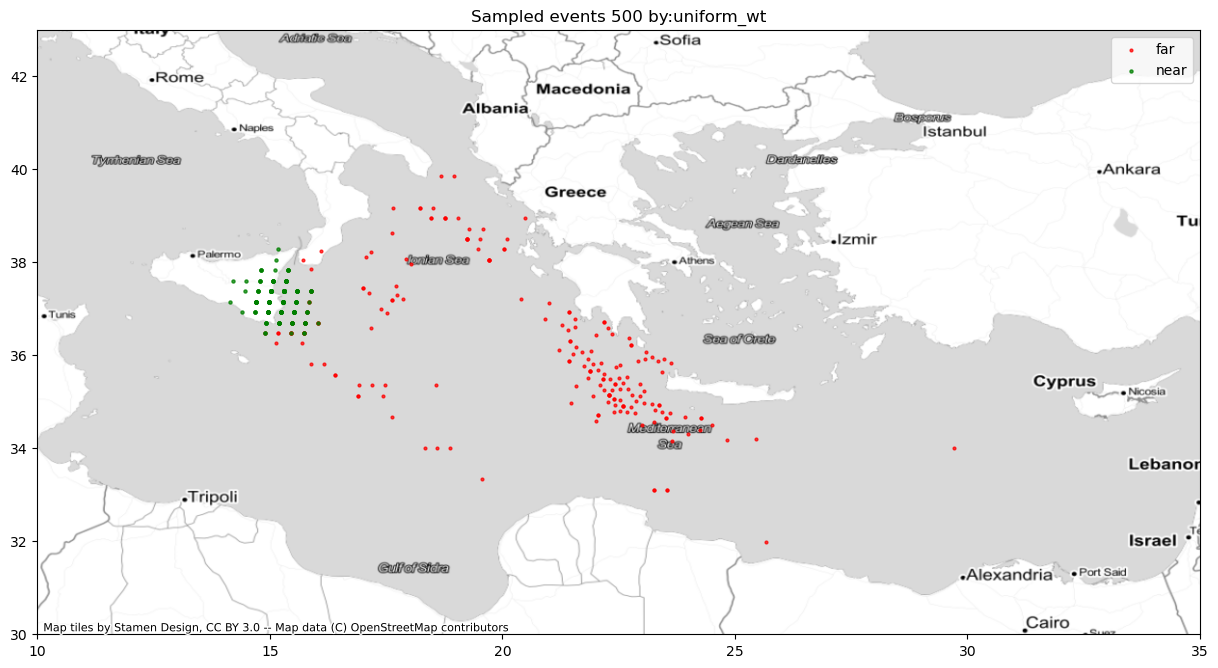

In [35]:
'split sampling in two steps for event type 0 and 1 then merge'
wt_para = 'uniform_wt' #'LocationCount', 'mean_prob', 'importance', 'uniform_wt'

sample_step0 = sample_train_events(combined.groupby('event_type').get_group(0),
                                importance_column=wt_para,
                                samples_per_bin=samples_per_bin,
                                bin_def = np.append(np.linspace(0,3.5,bin_splits), 99))

sample_step1 = sample_train_events(combined.groupby('event_type').get_group(1),
                                importance_column=wt_para, 
                                samples_per_bin=samples_per_bin,
                                bin_def = np.append(np.linspace(0,3.0,bin_splits), 99))

sample_test = pd.concat([pd.concat(sample_step0, axis=0), pd.concat(sample_step1, axis=0)], axis=0)

#check unique events in sample
print(len(sample_test['id'].unique()),'out of ',len(sample_test))

#merge columns from combined to sample_test based on id
sample_test = pd.merge(sample_test, combined, on='id', how='left')

#plot same but in multiple subplots as row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(sample_test[sample_test['event_type']==0]['max_off'], bins=bin_splits, alpha=0.5, label='near - max off')
axs[0].hist(sample_test[sample_test['event_type']==0]['max'], bins=bin_splits, alpha=0.5, label='near - max inun')
axs[0].text(0.5, 0.5, 'count of type 0 events: '+str(len(sample_test[sample_test['event_type']==0])))
axs[0].legend(loc='upper right')

axs[1].hist(sample_test[sample_test['event_type']==1]['max_off'], bins=bin_splits, alpha=0.5, label='far - max off')
axs[1].hist(sample_test[sample_test['event_type']==1]['max'], bins=bin_splits, alpha=0.5, label='far - max inun')
axs[1].text(0.5, 0.5, 'count of type 0 events: '+str(len(sample_test[sample_test['event_type']==1])))
axs[1].legend(loc='upper right')

axs[2].hist(sample_test['max_off'], bins=bin_splits, alpha=0.5, label='max off')
axs[2].hist(sample_test['max'], bins=bin_splits, alpha=0.5, label='max inun')
axs[2].text(0.5, 0.5, 'count of events: '+str(len(sample_test)))
axs[2].legend(loc='upper right')

fig, ax = plt.subplots(figsize=(15,10))
ax.title.set_text('Sampled events ' + str(len(sample_test)) + ' by:' + wt_para)
ax = plt.scatter(sample_test[sample_test['event_type']==1]['lon'], sample_test[sample_test['event_type']==1]['lat'], alpha=0.75, label='far',s=4, color='red')
ax = plt.scatter(sample_test[sample_test['event_type']==0]['lon'], sample_test[sample_test['event_type']==0]['lat'], alpha=0.75, label='near', s=5, color='green')
plt.legend(loc='upper right')
plt.xlim(10, 35)
plt.ylim(30, 43)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.Stamen.TonerLite)
plt.show()


In [68]:
# #check common ids in two lists
le = '2000'
CTlist=pd.read_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/events/sample_events{le}_CT_41.txt', header=None)
SRlist=pd.read_csv(f'/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/data/events/sample_events{le}_SR_54.txt', header=None)

#check common ids in two lists
print(len(set(CTlist[0]).intersection(set(SRlist[0]))))


220


In [74]:
size_list = ['500','1000','2000']
reg_list = ['CT','SR']

for reg in reg_list:
    for size in size_list:
        #select particular representative gauge    
        if reg == 'SR':
            columnname = str(54)
        elif reg == 'CT':
            columnname = str(41)

        #filter events with lower than threshold of 0.1 at atleast one station
        offshore_threshold = 0.1
        onshore_threshold = 0.25
        split = 0.75

        #offshore
        allpts_max = np.loadtxt(f'{MLDir}/data/info/grid0_allpts87_alleve53550.offshore.txt', dtype='str',skiprows=1)

        if reg == 'CT':
            GaugeNo = list(range(35,44)) #for Catania
            MainGauge = str(41) #for Catania
        elif reg == 'SR':
            GaugeNo = list(range(53,58)) #for Siracusa
            MainGauge = str(54) #for Siracusa

        event_list = np.loadtxt(f'{MLDir}/data/events/sample_events{size}_{reg}_{columnname}.txt', dtype='str') #for harcode

        #find index of event list in allpts_max wiht duplicate events
        event_list_index = np.array([np.where(allpts_max[:,0]==event)[0] for event in event_list]).flatten()
        allpts_max = allpts_max[event_list_index]
        Gauge_Max = allpts_max[:,GaugeNo]
        maxPerEve = Gauge_Max.astype(float).max(axis=1)

        #onshore
        inun_info = np.loadtxt(f'{MLDir}/data/info/CDepth_{reg}_alleve53550.onshore.txt', dtype='str',skiprows=1)
        inun_info = inun_info[event_list_index]
        Inun_Max = inun_info[:,2] #max inundation depth is the 3rd column

        #filter events greater than thresholds for gauge and min inundation depth
        offshore_check = maxPerEve>offshore_threshold
        onshore_check = Inun_Max.astype(float)>onshore_threshold
        print(len(event_list), len(offshore_check), len(onshore_check))

        overall_check = offshore_check & onshore_check
        event_list = event_list[overall_check]

        #shuffle events
        np.random.shuffle(event_list)

        #split events in train and test and validation as 60:20:20
        train_events = event_list[:int(len(event_list)*split)] 
        test_events = event_list[int(len(event_list)*split):]

        print(len(train_events), len(test_events))

        #save events in file
        np.savetxt(f'{MLDir}/data/events/shuffled_events_{reg}_{size}.txt', event_list, fmt='%s')
        np.savetxt(f'{MLDir}/data/events/train_events_{reg}_{size}.txt', train_events, fmt='%s')
        np.savetxt(f'{MLDir}/data/events/test_events_{reg}_{size}.txt', test_events, fmt='%s')

500 500 500
371 124
1000 1000 1000
743 248
2000 2000 2000
1485 496
500 500 500
366 123
1000 1000 1000
741 248
2000 2000 2000
1473 491
